In [107]:
import numpy as np
import pandas as pd
import math
from scipy.stats import hypergeom
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns

from functools import cache

%matplotlib inline
%config Completer.use_jedi = False

In [108]:
MIN_PER_EPOCH_CHURN_LIMIT = 4
CHURN_LIMIT_QUOTIENT = 65_536

VALIDATOR_NUMBER_14_JULY_2023 = 664_205
CUR_VALIDATORS = VALIDATOR_NUMBER_14_JULY_2023

EPOCHS_IN_DAY = 225

In [109]:
def get_validator_churn_limit(n):
    '''
    n: number of active validators
    '''
    # NOTE: The churn limit is an integer, but
    # we use a FP number here to smooth the plot.
    return max(MIN_PER_EPOCH_CHURN_LIMIT, n / CHURN_LIMIT_QUOTIENT)

In [110]:
def get_analysis_cdf(cur_validators, committee_participation_count, threshold = 1):
    days_passed = 0
    xs,ys,zs = [],[], []
    red_flag = yellow_flag = green_flag = False
    red_safety, yellow_safety, green_safety = 2**(-20), 2**(-40), 2**(-80)
    # green = yellow = red = None
    while True:
        days_passed += 1
        churn = int(get_validator_churn_limit(cur_validators))*EPOCHS_IN_DAY*days_passed

        hypergeom_cdf = 0
        for i in range(committee_participation_count,512):
            hypergeom_cdf += hypergeom.pmf(i, cur_validators, churn, 512)

        xs.append(days_passed)
        ys.append(hypergeom_cdf)
        zs.append(churn/cur_validators)

        if (hypergeom_cdf > red_safety) & (not red_flag):
            red = (days_passed, hypergeom_cdf, 'red',churn/cur_validators)
            red_flag = True
        elif (hypergeom_cdf > yellow_safety) & (not yellow_flag):
            yellow = (days_passed, hypergeom_cdf, 'orange',churn/cur_validators)
            yellow_flag = True
        elif (hypergeom_cdf > green_safety) & (not green_flag):
            green = (days_passed, hypergeom_cdf, 'green',churn/cur_validators)
            green_flag = True

        if hypergeom_cdf >= threshold:
            return xs, ys, zs, red, yellow , green

# % Malicious validators to No. days relationship
def perc_malicious_plot(xs, ys, zs, red, yellow , green, total_validators, offset = 0):
    
    fig, ax1 = plt.subplots()
    ax1.plot(xs,zs)
    ax1.set_xlabel('Days Passed')
    ax1.set_ylabel('% malicious validators')
    for (days, value, color,perc) in [green, yellow, red]:
        x = days,
        y = zs[days-offset]
        plt.scatter([x], [y], c=color)
    
    ax2 = ax1.twinx()
    ax2.plot(xs,[i*total_validators for i in zs])
    ax2.set_ylabel('Corrupted Validators')
    plt.title(f'Total Validators: {total_validators}')
    plt.show()
        
def get_analysis_plot(xs, ys, zs, red, yellow, green, total_validators, name):
    
    # Clean data and align
    ys = [i for i in ys if i!=0]
    offset = len(xs) - len(ys)
    xs = xs[offset:]
    zs = zs[offset:]
    
    # Log risk as a function of time
    fig_log = pd.Series(
            np.log10(ys),
            index = xs,
        ).plot(
            xlabel='Days passed',
            ylabel='Risk (log)',
            figsize=(8, 4),
        )

    for (days, value, color, perc) in [green, yellow, red]:
        x = days,
        y = np.log10(value)
        plt.scatter([x], [y], c=color)


    plt.axvline(green[0], np.log10(green[1]), alpha=.5)
    plt.text(green[0], -300, f' Cutoff\n {round(green[3],3)}')


    # Risk as a function of time
    fig = pd.Series(
            ys,
            index = xs,
        ).plot(
            xlabel='Days passed',
            ylabel='Risk',
            figsize=(8, 4),
            secondary_y=True,
        )

    for (days, value, color,perc) in [green, yellow, red]:
        x = days,
        y = value
        plt.scatter([x], [y], c=color)

    plt.axvline(green[0], green[1], alpha=.5)
    plt.savefig('../assets/risk-%s.png' % name)
    plt.show()
    
    perc_malicious_plot(xs, ys, zs, red, yellow, green, total_validators, offset)

'Malicious' are all potential validators that could have exited the validator pool, maximum entry of new validators is also assumed so that the churn rate remains the absolute highest - this is our worst case scenario.

### Hypergeometric Distribution

In YDM's analysis he uses the binomial CDF to compute the days-to-threshold measure, I've expanded on his analysis and used the hypergeometric CDF to compute the same measure, the improvements are quite negligable, because the hypergeometric distribution extends the binomial distribution, by taking into account that once an exited validator is selected for a committee, it exits the pool of potential validators to be selected. 

Since 'Validator Count' and 'Exited Validators' are proportional to each other and much larger than the committee size, which is of a constant size - 512. As the total number of validators and consequently the validator churn increases the difference will grow even smaller, however it is still a more precise way to achieve this computation.

### Risk profile for a validator pool of size CUR_VALIDATORS and 2/3 Sync Committee participation rate 

664205
65536
10.134963989257812
720896


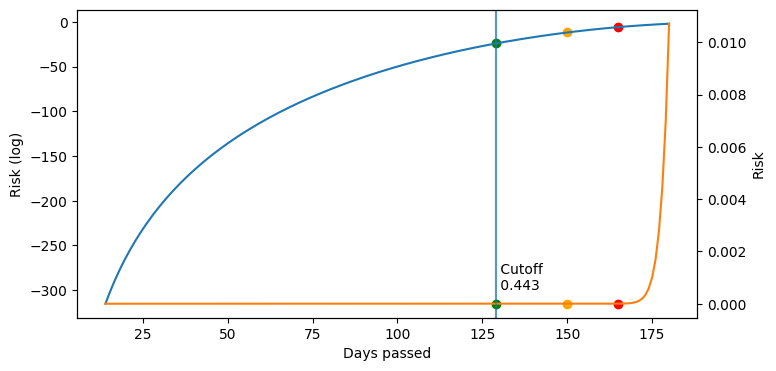

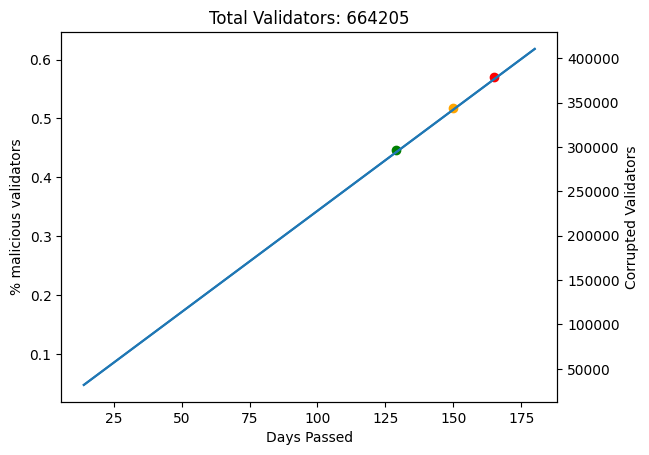

In [111]:
total_validators_worst = math.ceil(CUR_VALIDATORS / CHURN_LIMIT_QUOTIENT) * CHURN_LIMIT_QUOTIENT
get_analysis_plot(*get_analysis_cdf(total_validators_worst,342,.01),CUR_VALIDATORS, "23")

### Risk profile for a validator pool of size CUR_VALIDATORS and 95% Sync Committee participation rate 

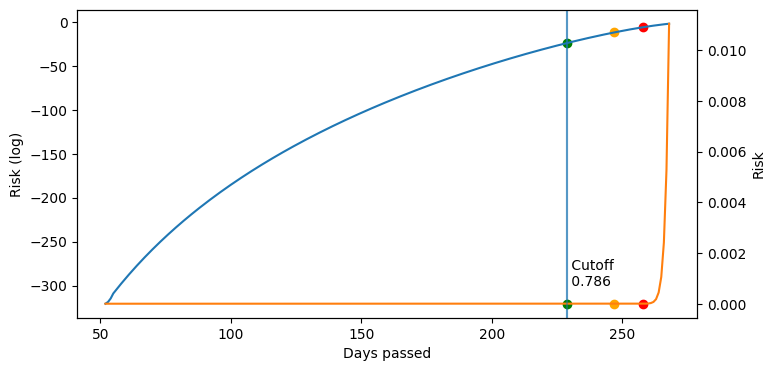

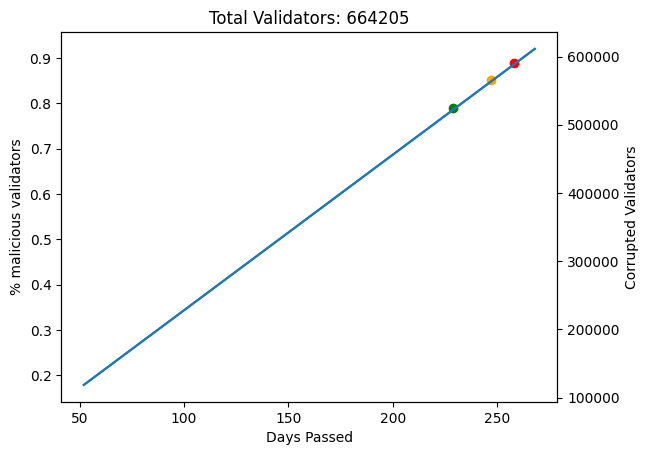

In [112]:
total_validators_worst = math.ceil(CUR_VALIDATORS / CHURN_LIMIT_QUOTIENT) * CHURN_LIMIT_QUOTIENT
get_analysis_plot(*get_analysis_cdf(total_validators_worst,485,.01),CUR_VALIDATORS, "95")

#### Explore Seasonality in Days-to-threshold

Since in the worst-case scenario the validator churn remains constant. There is some seasonality depending on the remainder of our current validator count when divided by CHURN_LIMIT_QUOTIENT. In the following experiment I explore how many days does it take to reach some of our predefined safety thresholds.

In [113]:
 xs, green, red, all_exp = [], [], [], []

 for i in range(1,100):
     val_count = 65_536*(4+i) - 1
     xs.append(val_count)
     analysis =  get_analysis_cdf(val_count,342,1 - .5)
     all_exp.append(analysis)
     points = analysis[3:]
     green.append(points[2][0])
     red.append(points[0][0])

In [114]:
 df = pd.DataFrame()
 df['num_validators'] = pd.Series(xs,index=xs)
 df['empirical_green'] = pd.Series(green,index=xs)
 df['empirical_red'] = pd.Series(red,index=xs)

In [115]:
 df_10 = df.copy() # Precomupted
 df_exact = df.copy() # Precomupted

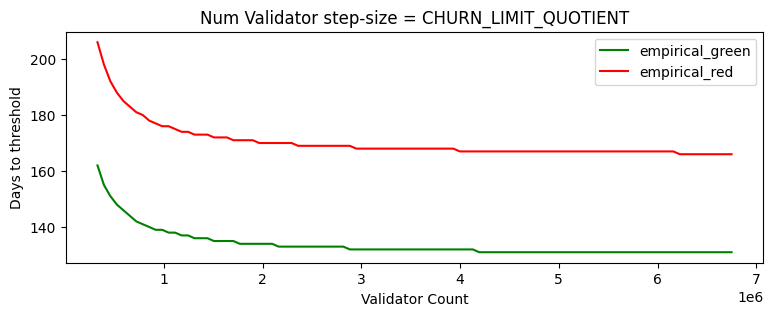

In [116]:
df_exact[['empirical_green','empirical_red']].plot(
    title='Num Validator step-size = CHURN_LIMIT_QUOTIENT',
    figsize=(9,3),
    xlabel='Validator Count',
    ylabel='Days to threshold',
    color={
        'empirical_green': 'g',
        'empirical_red': 'r'
    }
);

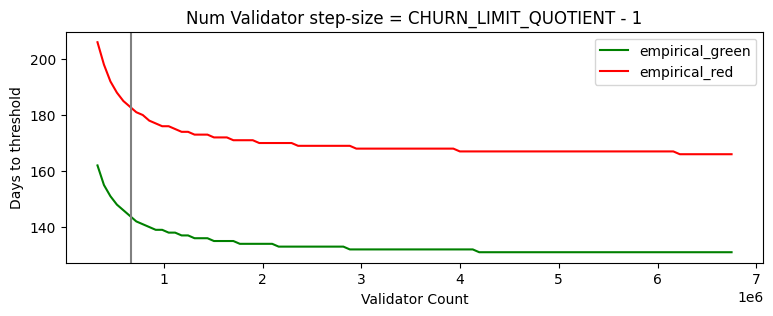

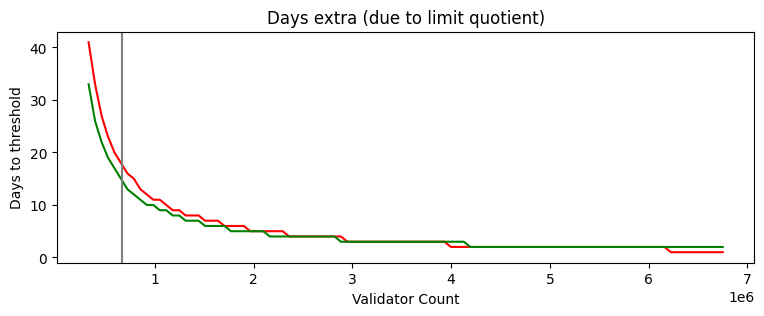

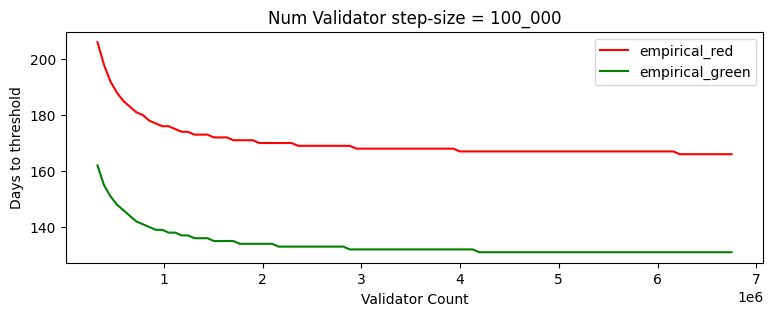

In [117]:
df[['empirical_green','empirical_red']].plot(
    title='Num Validator step-size = CHURN_LIMIT_QUOTIENT - 1',
    figsize=(9,3),
    color={
        'empirical_green': 'g',
        'empirical_red': 'r'
    },
    xlabel='Validator Count',
    ylabel='Days to threshold',
)
plt.axvline(CUR_VALIDATORS, color='.5');
plt.show()

(df['empirical_red'] - 165).plot(
    title='Days extra (due to limit quotient)',
    figsize=(9,3),
    color='r',
    xlabel='Validator Count',
    ylabel='Days to threshold',
)
(df['empirical_green'] - 129).plot(color='g')
plt.axvline(CUR_VALIDATORS, color='.5');
# plt.xlabel('')

df_10[['empirical_red','empirical_green']].plot(
    title='Num Validator step-size = 100_000',
    figsize=(9,3),
    color={
        'empirical_green': 'g',
        'empirical_red': 'r'
    },
    xlabel='Validator Count',
    ylabel='Days to threshold'
);

When the the validator count is exactly divisible by CHURN_LIMIT_QUOTIENT, then the days-to-threshold value remains constant, however if the remainder of validator_count divided by the limit quotient is exactly CHURN_LIMIT_QUOTIENT - 1, then there are the most possible extra days, which slowly diminish as the validator count reaches into the millions.

You can see from the arbitrary 100_000 step-size simulation, how the Days-to-threshold measure oscillates around the constant value.


### Detecting sync committee corruption when long-range syncing

In [118]:
get_analysis_cdf(total_validators_worst,485,.01)[3:]

((258, 1.133406237883174e-06, 'red', 0.885772705078125),
 (247, 1.3967303051043339e-12, 'orange', 0.8480072021484375),
 (229, 1.3865719837455257e-24, 'green', 0.7862091064453125))

For a 95% participation rate, even 78% exited validators yields a probablity of less than 10**(-24) to have an exited supermajority by random chance.

There is however vulnerability to an adaptive attack, where the adversary targets acquisition of validator keys for a specific committee, however the attacker is incentivized to corrupt a recent committee since otherwise it would be much more difficult to imitate the authentic state of the blockchain.

In case of a distant committee corruption event, you can refer to my analysis in the simulated_committees notebook for a proposed safe-guard